<a href="https://colab.research.google.com/github/yhyudha/analisis-data/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Analisis Data: [E-commerce-public-dataset]
- **Nama:** [Yudha]
- **Email:** [yohannes.haryo@lintasarta.co.id]
- **ID Dicoding:** [Y.H Yudha]

## Menentukan Pertanyaan Bisnis

- Produk apakah yang paling laku dan paling tidak laku di jual
- Negara Bagian mana yang paling banyak melakukan pembelian

## Import Semua Packages/Library yang Digunakan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import plotly.express as px
from babel.numbers import format_currency
import os

## Data Wrangling

### Gathering Data

In [ ]:
# Load datasets
# # Path dinamis ke folder Data
BASE_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Data'))
customers_dataset_df = pd.read_csv(os.path.join(BASE_PATH, "customers_dataset.csv"))
geolocation_dataset_df = pd.read_csv(os.path.join(BASE_PATH, "geolocation_dataset.csv"))
order_items_dataset_df = pd.read_csv(os.path.join(BASE_PATH, "order_items_dataset.csv"))
order_payments_dataset_df = pd.read_csv(os.path.join(BASE_PATH, "order_payments_dataset.csv"))
order_reviews_dataset_df = pd.read_csv(os.path.join(BASE_PATH, "order_reviews_dataset.csv"))
orders_dataset_df = pd.read_csv(os.path.join(BASE_PATH, "orders_dataset.csv"))
product_category_name_translation_df = pd.read_csv(os.path.join(BASE_PATH, "product_category_name_translation.csv"))
products_dataset_df = pd.read_csv(os.path.join(BASE_PATH, "products_dataset.csv"))
sellers_dataset_df = pd.read_csv(os.path.join(BASE_PATH, "sellers_dataset.csv"))


**Insight:**
- Untuk akses menggunakan os.path karena folder yang berbeda antara folder dashboard dengan folder data-data csv.

### Assessing Data

In [ ]:
# # orders_dataset
orders_dataset_df.head()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(orders_dataset_df.head())

orders_dataset_df.info()
orders_dataset_df.isna().sum()
print(orders_dataset_df.isna().sum())
print("Jumlah duplikasi: ", orders_dataset_df.duplicated().sum())
orders_dataset_df.describe()
print(orders_dataset_df.describe())

orders_dataset_df[orders_dataset_df.order_approved_at.isna()]
print(orders_dataset_df[orders_dataset_df.order_approved_at.isna()])
orders_dataset_df.groupby(by="order_status")
print(orders_dataset_df)

**Insight:**
- Melihat bahwa ada beberapa kolom kosong yaitu yang jika order_status : " canceled " , maka kolom approved time, deivery time dll akan kosong karena tidak ada nya pembelian dan pengiriman barang

### Cleaning Data

In [ ]:
datetime_columns = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]

for column in datetime_columns:
    orders_dataset_df[column] = pd.to_datetime(orders_dataset_df[column])

orders_dataset_df.info()


**Insight:**
- Memperbaiki tipe data untuk Waktu menjadi datetime64
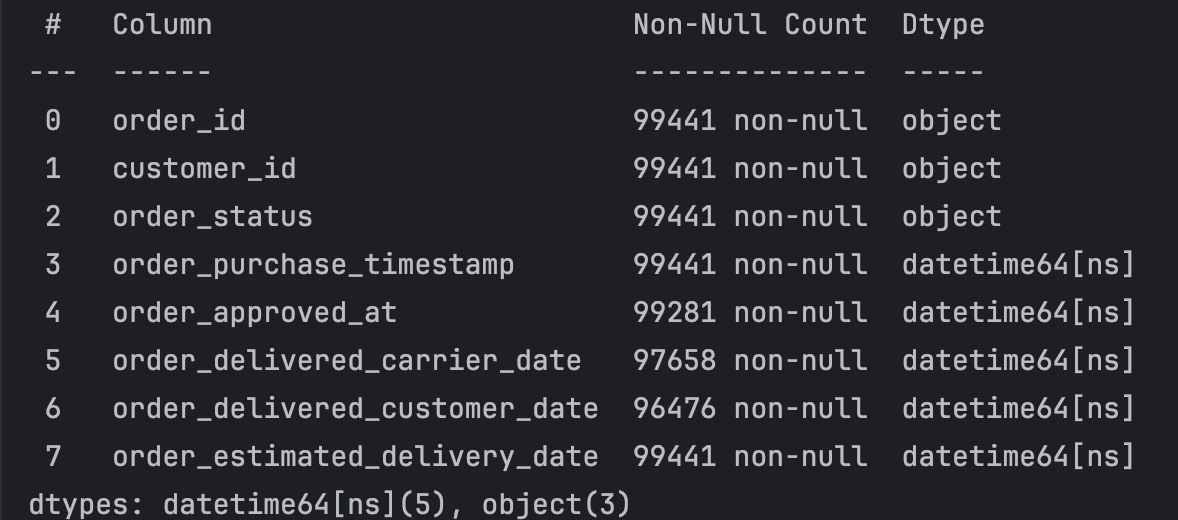


## Exploratory Data Analysis (EDA)

### Explore ...

In [ ]:
# Gabungkan dataset
# # dataset-Product performance
order_product_df = pd.merge(order_items_dataset_df, orders_dataset_df, on="order_id", how="inner")
order_product_df = pd.merge(order_product_df, products_dataset_df, on="product_id", how="inner")
order_product_df = pd.merge(order_product_df, product_category_name_translation_df, on="product_category_name", how="left")

# # dataset-Demography
order_customer_df = pd.merge(order_items_dataset_df, orders_dataset_df, on="order_id", how="inner")
order_customer_df = pd.merge(order_customer_df, customers_dataset_df, on="customer_id", how="inner")

# # dataset-RFM
customer_order_df = pd.merge(customers_dataset_df, orders_dataset_df, on="customer_id", how="inner")
customer_order_df = pd.merge(customer_order_df, order_items_dataset_df, on="order_id", how="left")


# Helper function yang dibutuhkan untuk menyiapkan berbagai dataframe
def create_sum_order_items_df(df):
    sum_order_items_df = (
        df.groupby("product_category_name_english")["order_id"]
        .nunique()
        .sort_values(ascending=False)
        .reset_index(name="total_orders")
    )
    return sum_order_items_df

def create_bystate_df(df):
    bystate_df = df.groupby(by="customer_state").customer_id.nunique().reset_index()
    bystate_df.rename(columns={"customer_id": "customer_count"}, inplace=True)
    return bystate_df

def create_rfm_df(df):
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
    recent_date = df["order_purchase_timestamp"].max().date()
    rfm_df = df.groupby("customer_id", as_index=False).agg({
        "order_purchase_timestamp": "max",
        "order_id": "nunique",
        "price": "sum"
    })
    rfm_df.columns = ["customer_id", "last_purchase_date", "frequency", "monetary"]
    rfm_df["last_purchase_date"] = rfm_df["last_purchase_date"].dt.date
    rfm_df["recency"] = rfm_df["last_purchase_date"].apply(lambda x: (recent_date - x).days)
    rfm_df.drop("last_purchase_date", axis=1, inplace=True)
    return rfm_df


# Menyiapkan berbagai dataframe
sum_order_items_df = create_sum_order_items_df(order_product_df)
bystate_df = create_bystate_df(order_customer_df)
rfm_df = create_rfm_df(customer_order_df)


**Insight:**
- Merge beberapa dataset sesuai kebutuhan.
- Membuat Function untuk Best dan Worst selling product
- Membuat function untuk jumlah pelanggan terbanyak menurut negaranya
- Membaut Function AnalisiS RFM

## Visualization & Explanatory Analysis

### Pertanyaan 1:


In [ ]:
# Panggil fungsi dan tampilkan hasilnya
sum_order_items_df = create_sum_order_items_df(order_product_df)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), dpi=100)
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

# Best Performing
sns.barplot(
    x="total_orders",
    y="product_category_name_english",
    data=sum_order_items_df.head(5),
    hue="product_category_name_english",
    palette=colors,
    ax=ax[0],
    legend=False
)
ax[0].set_ylabel(None)
ax[0].set_xlabel("Number of Orders", fontsize=12)
ax[0].set_title("Best Performing Product", loc="center", fontsize=14)
ax[0].tick_params(axis='y', labelsize=10)
ax[0].tick_params(axis='x', labelsize=10)

# Worst Performing
sns.barplot(
    x="total_orders",
    y="product_category_name_english",
    data=sum_order_items_df.sort_values(by="total_orders", ascending=True).head(5),
    hue="product_category_name_english",
    palette=colors,
    ax=ax[1],
    legend=False
)
ax[1].set_ylabel(None)
ax[1].set_xlabel("Number of Orders", fontsize=12)
ax[1].set_title("Worst Performing Product", loc="center", fontsize=14)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].tick_params(axis='x', labelsize=10)

# Tampilkan di Streamlit
st.pyplot(fig)

### Pertanyaan 2:

In [ ]:
bystate_df = create_bystate_df(order_customer_df)

# Sort and create colors
sorted_df = bystate_df.sort_values(by="customer_count", ascending=False)
colors = ["#90CAF9" if i == 0 else "#D3D3D3" for i in range(len(sorted_df))]

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x="customer_count",
    y="customer_state",
    data=sorted_df,
    palette=colors,
    ax=ax
)
ax.set_title("Number of Customers by State", loc="center", fontsize=30)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=15)

# Display in Streamlit
st.pyplot(fig)


**Insight:**
- Product Performance Overview
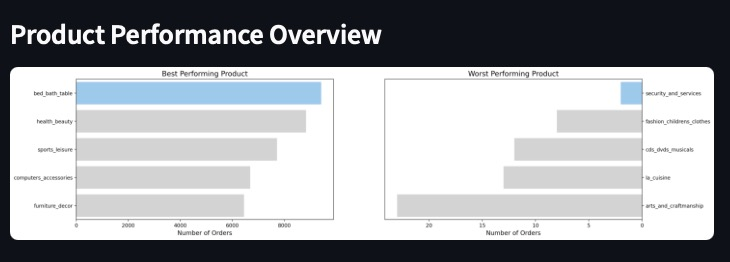
- Customer Demography by State
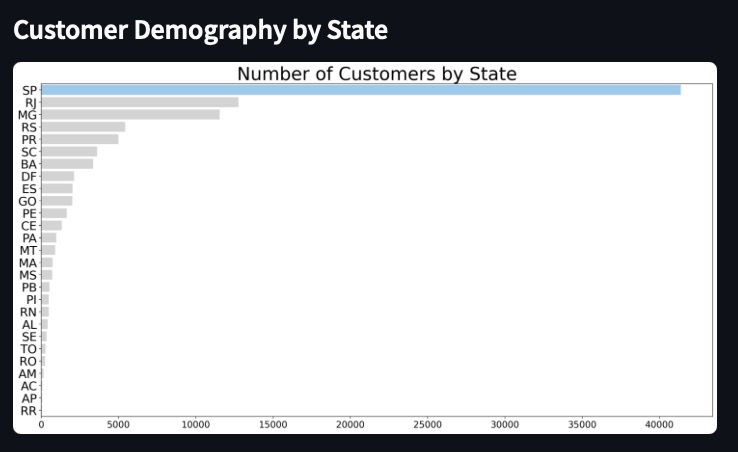

## Analisis Lanjutan (Opsional)

In [ ]:
# Fungsi RFM
def create_rfm_df(df):
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
    recent_date = df["order_purchase_timestamp"].max().date()

    rfm_df = df.groupby("customer_id", as_index=False).agg({
        "order_purchase_timestamp": "max",
        "order_id": "nunique",
        "price": "sum"
    })

    rfm_df.columns = ["customer_id", "last_purchase_date", "frequency", "monetary"]
    rfm_df["last_purchase_date"] = rfm_df["last_purchase_date"].dt.date
    rfm_df["recency"] = rfm_df["last_purchase_date"].apply(lambda x: (recent_date - x).days)
    rfm_df.drop("last_purchase_date", axis=1, inplace=True)

    return rfm_df

rfm_df = create_rfm_df(customer_order_df)

# Display RFM Metrics
st.subheader("Best Customer Based on RFM Parameters")

col1, col2, col3 = st.columns(3)

with col1:
    avg_recency = round(rfm_df.recency.mean(), 1)
    st.metric("Average Recency (days)", value=avg_recency)

with col2:
    avg_frequency = round(rfm_df.frequency.mean(), 2)
    st.metric("Average Frequency", value=avg_frequency)

with col3:
    avg_monetary = format_currency(rfm_df.monetary.mean(), "AUD", locale='es_CO')
    st.metric("Average Monetary", value=avg_monetary)

# Visualisasi Top Customers
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(35, 15))
colors = ["#90CAF9"] * 5

sns.barplot(
    y="recency",
    x="customer_id",
    hue="customer_id",
    data=rfm_df.sort_values(by="recency", ascending=True).head(5),
    palette=colors,
    ax=ax[0],
    legend=False
)
ax[0].set_title("By Recency (days)", loc="center", fontsize=50)
ax[0].set_xlabel("customer_id", fontsize=30)
ax[0].tick_params(axis='x', labelsize=35)
ax[0].tick_params(axis='y', labelsize=30)
ax[0].tick_params(axis='x', labelrotation=85)
sns.barplot(
    y="frequency",
    x="customer_id",
    hue="customer_id",
    data=rfm_df.sort_values(by="frequency", ascending=False).head(5),
    palette=colors,
    ax=ax[1],
    legend=False
)
ax[1].set_title("By Frequency", loc="center", fontsize=50)
ax[1].set_xlabel("customer_id", fontsize=30)
ax[1].tick_params(axis='x', labelsize=35)
ax[1].tick_params(axis='y', labelsize=30)
ax[1].tick_params(axis='x', labelrotation=85)

sns.barplot(
    y="monetary",
    x="customer_id",
    hue="customer_id",
    data=rfm_df.sort_values(by="monetary", ascending=False).head(5),
    palette=colors,
    ax=ax[2],
    legend=False
)
ax[2].set_title("By Monetary", loc="center", fontsize=50)
ax[2].set_xlabel("customer_id", fontsize=30)
ax[2].tick_params(axis='x', labelsize=35)
ax[2].tick_params(axis='y', labelsize=30)
ax[2].tick_params(axis='x', labelrotation=85)

st.pyplot(fig)


## Conclusion

- bed bath _table merupakan produk yang paling banyak terjual dan security_and _services merupakan produk paling sedikit terjual
- customer paling paling banyak berada di state SP dan customer paling sedikit berada di state RR

- Best Customer Based on RFM Parameters
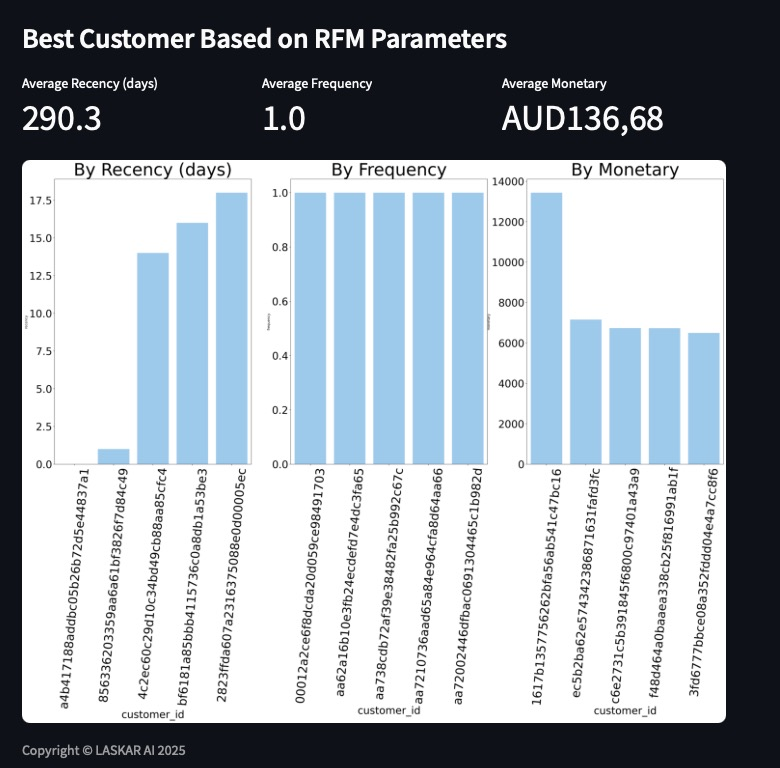